In [2]:
import json
import numpy as np
import pandas as pd
import os
import h5py

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
X = []
y = []
with h5py.File("behaviours.hdf5", 'r') as ds:
    for i, key in enumerate(ds):
        print("Loading", key)
        X.append(ds[key][...])
        y.append(np.ones(ds[key].shape[0])*i)
        
        
X = np.concatenate(X, axis=0)
X[np.isnan(X)] = 0
y = np.concatenate(y, axis=0)

print(X.shape, y.shape)

Loading frontal_swings_upwards
Loading lateral_rotations_clockwise
Loading marker_up
Loading marker_up_frontal_swing
Loading marker_up_lateral_rotations
Loading marker_up_lateral_swing
Loading motor_marker_1
Loading random_motions
(92514, 13) (92514,)


In [5]:
# Pose information (= motor camera image, (x,y,z) + quaternion)
X_pose = X[:,0:7]
# Motor displacements
X_disp = X[:,7:]
X_disp[X_disp < 0] = 0

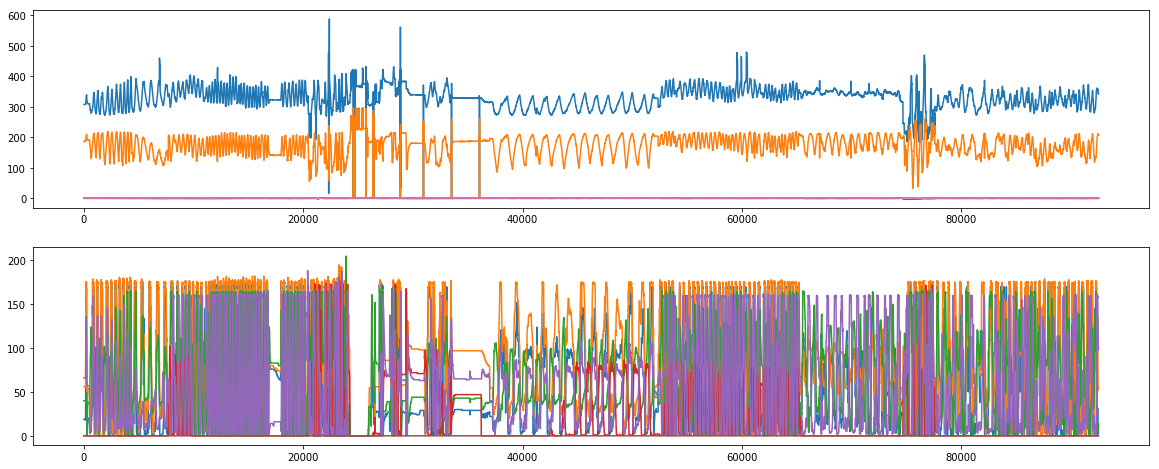

In [6]:
_, axes = plt.subplots(2,1,figsize=(20,8))
axes[0].plot(X_pose)
axes[1].plot(X_disp)
plt.show()

In [7]:
from sklearn.decomposition import PCA

def get_pca(X):
    mu = X.mean(axis=-1,keepdims=True)
    sd = 1e-5 + X.std(axis=-1,keepdims=True)
    X_ = (X - mu) / sd
    pca = PCA(n_components=2)
    f = pca.fit_transform(X_)
    return f

f_pose = get_pca(X_pose)
f_disp = get_pca(X_disp)

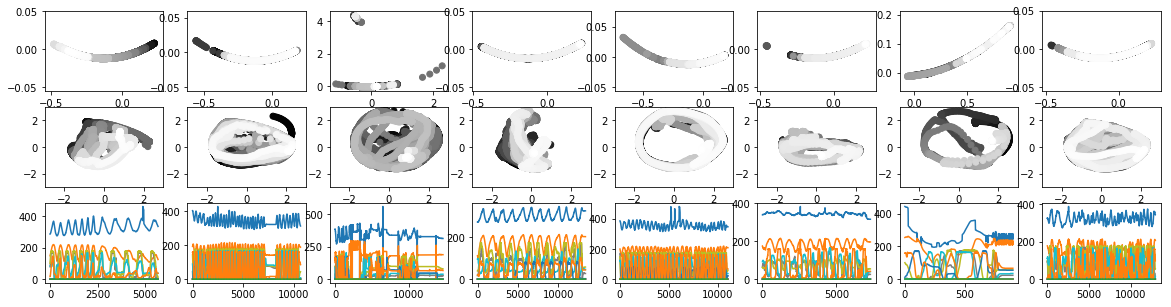

In [8]:
fig, axes = plt.subplots(3,len(np.unique(y)),figsize=(20,5))

id_start = 2000
id_stop  = 20000
idc = slice(id_start, id_stop)

for i in np.unique(y).astype("int"):
    c = np.arange(len(f_pose[y==i,0][idc]))
    
    axes[0,i].scatter(f_pose[y==i,0][idc], f_pose[y==i,1][idc], c = c, cmap="gray")
    #axes[0,i].set_xlim([-3,3])
    #axes[0,i].set_ylim([-3,3])
    
    axes[1,i].scatter(f_disp[y==i,0][idc], f_disp[y==i,1][idc], c = c, cmap="gray")
    axes[1,i].set_xlim([-3,3])
    axes[1,i].set_ylim([-3,3])
    
    axes[2,i].plot(X[y==i][idc])

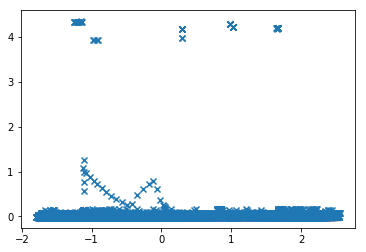

In [203]:
f_disp.shape, f_pose.shape

plt.scatter(f_disp[:,0], f_pose[:,1], marker='x')
plt.show()

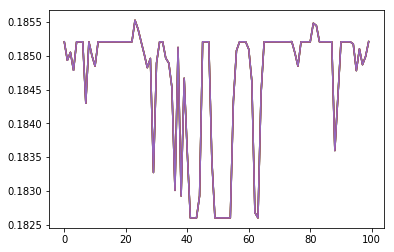

In [259]:
n_shift = 5

h_pose = np.roll(f_pose[:,np.newaxis].repeat(n_shift,axis=1), shift=tuple(range(n_shift)),\
                 axis=tuple([1]*n_shift))

plt.plot(h_pose[:100,:,0])
plt.show()

In [240]:
from sklearn.gaussian_process import GaussianProcessRegressor

d_pose = f_pose.copy()
d_pose[:-1] -= d_pose[1:]

gp = GaussianProcessRegressor(normalize_y=True)
gp.fit(np.concatenate([f_pose], axis=0)[::10], f_disp[::10])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [241]:
d_pred, d_std = gp.predict(np.concatenate([f_pose], axis=0)[:5000], return_std=True)

/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


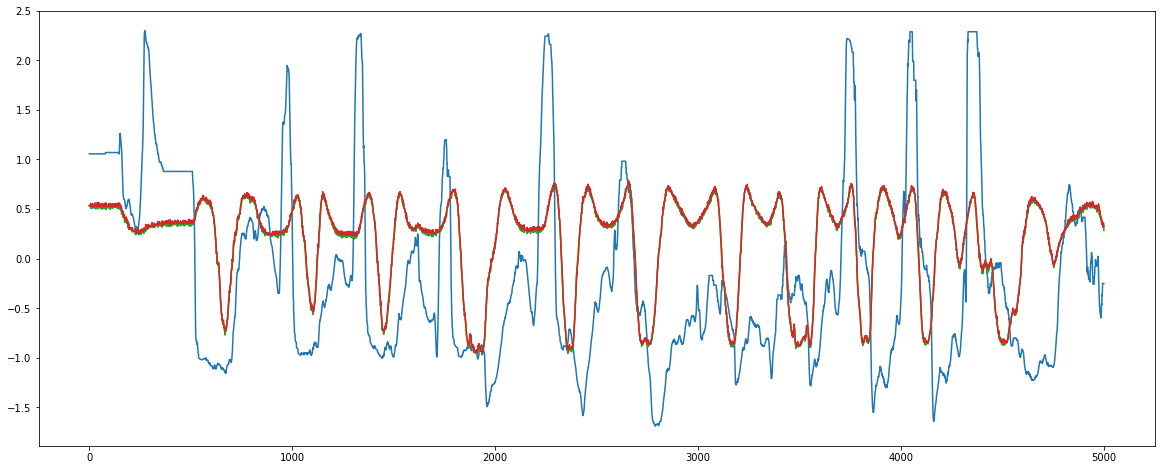

In [242]:
plt.figure(figsize=(20,8))
plt.plot(f_disp[:5000,0])
#plt.fill_between()
plt.plot(d_pred[:5000,0])
plt.plot((d_pred[:,0]-d_std)[:5000])
plt.plot((d_pred[:,0]+d_std)[:5000]) #, (d_pred[:,0]+d_std)[:5000])

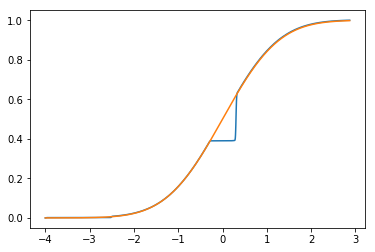

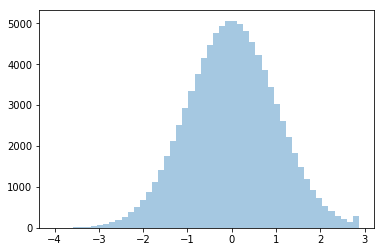

In [192]:
from scipy.interpolate import interp1d

def normalize(X):
    
    if X.ndim > 1:
        return np.stack([normalize(X[:,i]) for i in range(X.shape[1])], axis=1)
    
    std = X.std()
    X = np.clip(X/std, -4, 4) + np.random.normal(0,0.01,size=len(X))

    pdf, bins = np.histogram(X, bins=10000000, density=True)
    pdf /= pdf.sum()
    cdf = np.cumsum(pdf)

    plt.plot(bins[:-1], cdf)
    plt.plot(bins[:-1], norm.cdf(bins[:-1]))

    xx = bins[:]

    map1 = interp1d(xx, np.concatenate([cdf,np.zeros(1)]) )

    Hy = norm.cdf(xx)
    Hy[0] = 0
    Hy[-1] = 1

    map2 = interp1d(Hy, xx)
    
    return map2(map1(X))

y = normalize(d_disp[:,0])
plt.show()
sns.distplot(y, kde=None)
#plt.plot(xx, Hy)

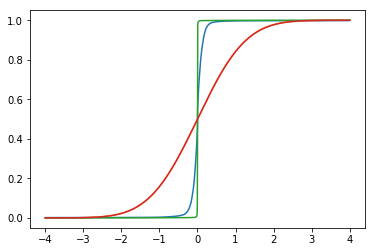

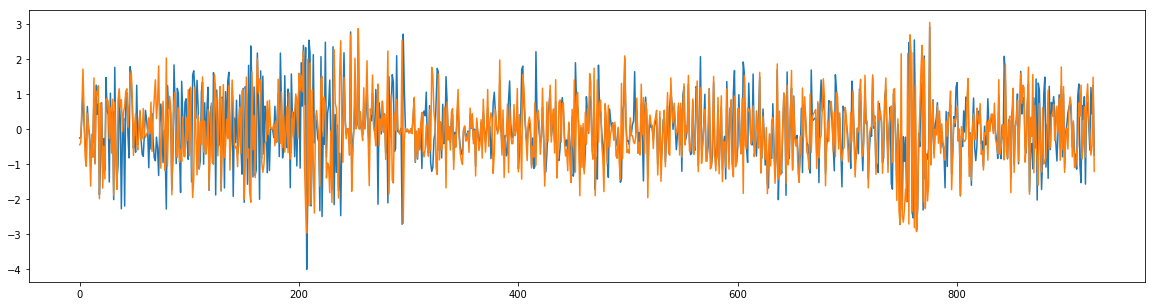

In [178]:
y = normalize(d_pose)

plt.figure(figsize=(20,5))
plt.plot(y[::100])

In [110]:
from scipy.stats import norm

def normalize_gaussian(X, axis=0):
    H_x = np.cumsum(X, axis=axis)
    H_y = norm.cdf()

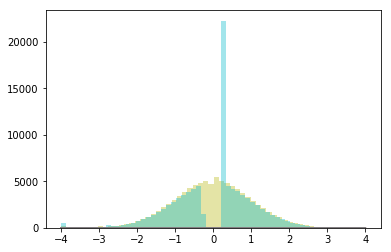

In [189]:
import seaborn as sns

d_pose = normalize(f_pose[1:] - f_pose[:-1])
d_disp = normalize(f_disp[1:] - f_disp[:-1])

sns.distplot(d_pose[...,0], kde=None)
sns.distplot(d_disp[...,1], kde=None)

In [186]:
#from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

gp = LinearRegression()
gp.fit(d_pose[:1000], d_disp[:1000,0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

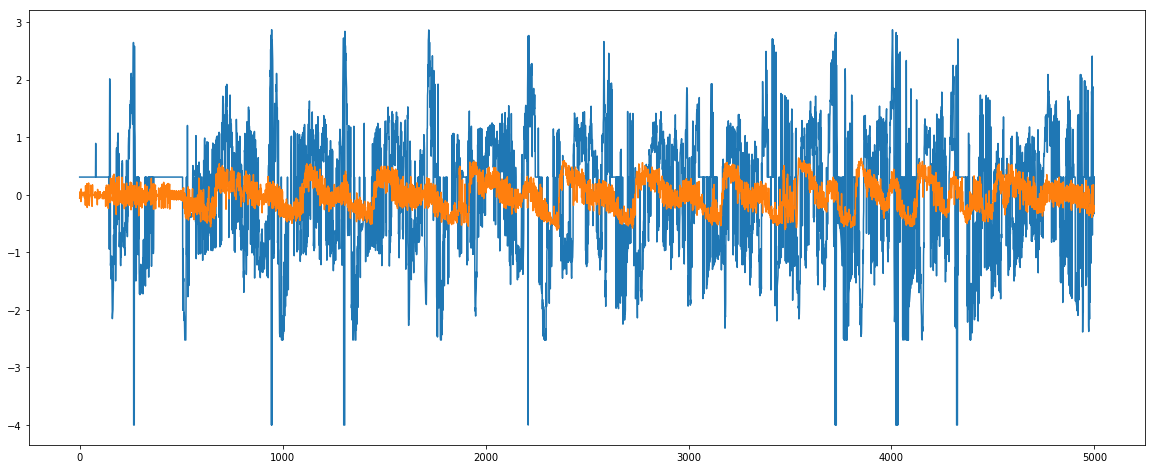

In [187]:
d_pred = gp.predict(d_pose[:5000])

plt.figure(figsize=(20,8))
plt.plot(d_disp[:5000,0])
plt.plot(d_pred)

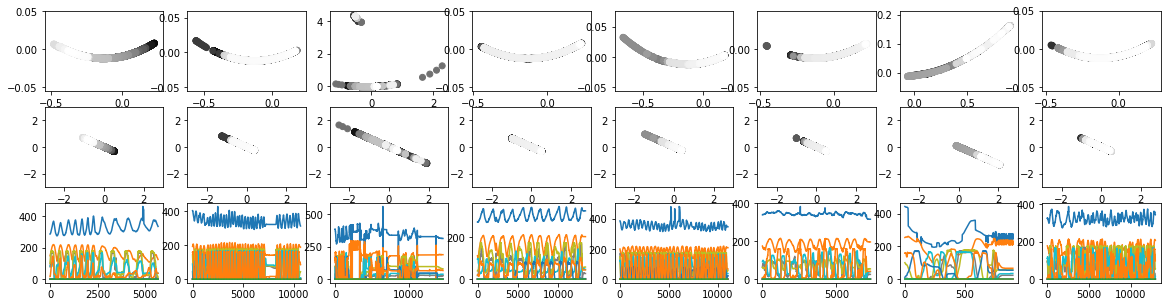

In [20]:
fig, axes = plt.subplots(3,len(np.unique(y)),figsize=(20,5))

id_start = 2000
id_stop  = 20000
idc = slice(id_start, id_stop)

for i in np.unique(y).astype("int"):
    c = np.arange(len(f_pose[y==i,0][idc]))
    
    axes[0,i].scatter(f_pose[y==i,0][idc], f_pose[y==i,1][idc], c = c, cmap="gray")
    
    axes[1,i].scatter(f_pred[y==i,0][idc], f_pred[y==i,1][idc], c = c, cmap="gray")
    axes[1,i].set_xlim([-3,3])
    axes[1,i].set_ylim([-3,3])
    
    axes[2,i].plot(X[y==i][idc])